In [1]:
camera=94706

In [2]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import auc
from keras.losses import mse


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

#Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing



#Sampling Libraries
from imblearn.over_sampling import SMOTE 

#Imputation Libraries
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Data
from sklearn.datasets import load_boston

#Costant Value
from sklearn.feature_selection import VarianceThreshold

#Encoding Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder


In [4]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive/SRH Heidelberg/Case Study 1/Codes-Sasha/00-Data/thermal_images/94706

/content/drive/My Drive/SRH Heidelberg/Case Study 1/Codes-Sasha/00-Data/thermal_images/94706


In [7]:
faulty_data=np.load(f"all_faulty_{camera}.npy")
healthy_data=np.load(f"healthy_{camera}.npy")

In [8]:
max=healthy_data.max()
min=healthy_data.min()
healthy_data=(healthy_data-min)/(max-min)
max=faulty_data.max()
min=faulty_data.min()
faulty_data=(faulty_data-min)/(max-min)

In [9]:
np.random.shuffle(faulty_data)
np.random.shuffle(healthy_data)

In [10]:
index=faulty_data.shape[0]
X_test=healthy_data[:index]
X=healthy_data[index:]
X_train=X[:round(X.shape[0]*.8)]
X_val=X[round(X.shape[0]*.8):]
X_fehler_test=faulty_data
test_data = np.concatenate((X_test,X_fehler_test),axis = 0)

In [11]:
print(f"""shape of data:
X_train-->{X_train.shape[0]}
X_val-->{X_val.shape[0]}
X_test-->{X_test.shape[0]}
X_fehler_test-->{X_fehler_test.shape[0]}
test_data-->{test_data.shape[0]}""")

shape of data:
X_train-->927
X_val-->232
X_test-->954
X_fehler_test-->954
test_data-->1908


In [12]:
%cd /content/drive/My Drive/SRH Heidelberg/Case Study 1/Codes-Sasha/00-Data/thermal_images/94706/Report Data

/content/drive/My Drive/SRH Heidelberg/Case Study 1/Codes-Sasha/00-Data/thermal_images/94706/Report Data


In [13]:
class Sampling(keras.layers.Layer):
  def call(self,inputs):
    mean,log_var=inputs
    return K.random_normal(tf.shape(log_var))*K.exp(log_var/2)+mean

#Encoder

In [14]:
input_dim = 32*32
intermediate_dim_1= int(input_dim/2)
intermediate_dim_2= int(input_dim/3)
latent_dim = int(input_dim/4)

In [15]:
inputs = Input(shape=[32,32])
z=Flatten()(inputs)
z=Dense(intermediate_dim_1,activation="selu",kernel_initializer='random_normal')(z)
z=Dense(intermediate_dim_2,activation="selu",kernel_initializer='random_normal')(z)
coding_mean=Dense(latent_dim)(z)
coding_log_var=Dense(latent_dim,kernel_initializer='zeros')(z)
codings=Sampling()([coding_mean,coding_log_var])
encoder=keras.Model(inputs=[inputs],outputs=[coding_mean,coding_log_var,codings])


#Decoder

In [16]:
# decoder takes the latent vector as input
decoder_inputs = Input(shape=[latent_dim])
x=Dense(intermediate_dim_2,activation="selu")(decoder_inputs)
x=Dense(intermediate_dim_1,activation="selu")(x)
x=Dense(32*32,activation="sigmoid")(x)
outputs=Reshape([32,32])(x)
decoder=Model(inputs=[decoder_inputs],outputs=[outputs])

In [17]:
_,_,codings=encoder(inputs)
reconstructions=decoder(codings)
vae=Model(inputs=[inputs],outputs=[reconstructions])

In [18]:
#latent_loss=-0.5*K.sum(1+coding_log_var-K.exp(coding_log_var)-K.square(coding_mean),axis=-1)
#vae.add_loss(K.mean(latent_loss)/1024)
#vae.compile(loss="mse",optimizer="rmsprop")

In [19]:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    latent_loss=-0.5*K.sum(1+coding_log_var-K.exp(coding_log_var)-K.square(coding_mean),axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + latent_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [20]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae.compile(optimizer=opt, loss=vae_loss)
vae.summary()
history=vae.fit(X_train,X_train,shuffle=True,epochs=32,batch_size=128)#validation_data=[X_val,X_val]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32)]          0         
                                                                 
 model (Functional)          [(None, 256),             874837    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 model_1 (Functional)        (None, 32, 32)            788053    
                                                                 
Total params: 1,662,890
Trainable params: 1,662,890
Non-trainable params: 0
_________________________________________________________________
Train on 927 samples
Epoch 1/32
927/927 [==============================] - 1s 967us/sample - loss: 7544.0279
Epoch 2/32
927/927 [==============================] - 0s 268us/sample - 

In [21]:
def KL_calc(encoder,X):
  codings_mean, codings_log_var,_ = encoder.predict(X,batch_size=64)
  latent_loss=-0.5*K.sum(1+codings_log_var-K.exp(codings_log_var)-K.square(codings_mean),axis=-1)
  return latent_loss

In [22]:
def calc_recon_error(batch_data):
  recon_error_list=[]
  for i in range(0, batch_data.shape[0]):
    data  = batch_data[i]
    reconstruction = vae.predict(data.reshape(1,32,32))
    reconstruction_error=((data-reconstruction)**2).sum()
    #reconstruction_error=np.sqrt(np.mean((data-reconstruction)**2,axis=1))

    recon_error_list.append(reconstruction_error) 
  return np.array(recon_error_list)


In [23]:
train_kl_errors=calc_recon_error(X_train)
anomaly_kl_errors= calc_recon_error(X_fehler_test)
normal_kl_errors=calc_recon_error(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


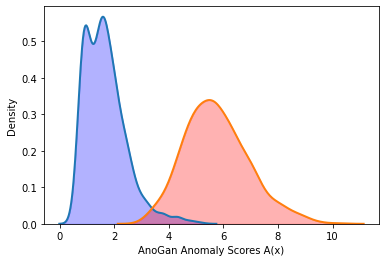

In [24]:
ax=sns.distplot(train_kl_errors, hist=False, kde=True, 
             bins=int(200),fit_kws={"color":"blue"},
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax=sns.distplot(anomaly_kl_errors, hist=False, kde=True, 
             bins=int(200),fit_kws={"color":"red"}, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='AnoGan Anomaly Scores A(x)', ylabel='Density')
l1 = ax.lines[0]
l2 = ax.lines[1]

x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="blue", alpha=0.3)
ax.fill_between(x2,y2, color="red", alpha=0.3)
plt.savefig(f'Anogan_dist{camera}.png')
plt.show(block=False)

In [25]:
def create_dataset(normal_kl_errors,anomally_kl_errors):
  dataset=np.row_stack((np.column_stack((normal_kl_errors,np.ones((normal_kl_errors.shape[0],),dtype=np.int64))),np.column_stack((anomally_kl_errors,np.zeros((anomally_kl_errors.shape[0],),dtype=np.int64)))))
  df=pd.DataFrame(dataset,columns=['kl_errors','label'])
  df = df.sample(frac=1).reset_index(drop=True)
  return df


In [26]:
df_scatter=create_dataset(np.array(train_kl_errors),np.array(anomaly_kl_errors))
df=create_dataset(np.array(normal_kl_errors),np.array(anomaly_kl_errors))

In [27]:
df.head()

,kl_errors,label
0,2.023901,1.0
1,8.514743,0.0
2,0.873921,1.0
3,5.614779,0.0
4,5.114248,0.0


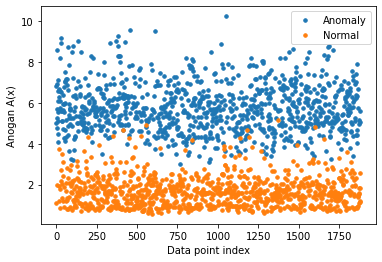

In [28]:
groups = df_scatter.groupby('label')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.kl_errors, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Anomaly")
ax.legend(loc='upper right')
plt.ylabel("Anogan A(x)")
plt.xlabel("Data point index")
plt.savefig(f'anogan_scatter{camera}.png')
plt.show();

In [29]:
test_kl_errors=df.kl_errors.to_numpy()
y_actual=df.label.to_numpy()
test_labels=df.label.to_numpy()


#Area under the curve (AUC) of the Receiver Operating Characteristic (ROC)

In [30]:
class Classifier:
  def classify(self,test_kl_error,threshold):
    if test_kl_error < threshold:
      pred_label = 1
    else:
       pred_label = 0
    return (pred_label)
  def metrics(self,y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
      if y_actual[i] == y_pred[i] == 1:
        TP += 1
      elif y_pred[i] == 1 and y_actual[i] != y_pred[i]:
        FP += 1
      elif y_actual[i] == y_pred[i] == 0:
        TN +=1
      elif y_pred[i] == 0 and y_actual[i] != y_pred[i]:
        FN+=1

    return (TP, FP,TN,FN)

In [31]:
classifier = Classifier()
tpr=[]
fpr=[]
thresholds=[]

for threshold in np.linspace(train_kl_errors.min(),train_kl_errors.max(),num=30):
  y_pred=[]
  for error in test_kl_errors:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)
  TP,FP,TN,FN = classifier.metrics(y_actual,y_pred)
  tpr.append(TP/(TP+FN))
  fpr.append(FP/(FP+TN))
  thresholds.append(threshold)

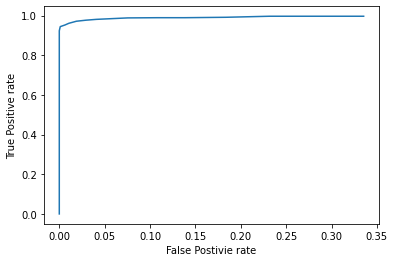

In [32]:
plt.plot(fpr,tpr)
plt.xlabel("False Postivie rate")
plt.ylabel("True Positive rate")
plt.show()

In [33]:
y_pred=[]
threshold = train_kl_errors.max()

for error in test_kl_errors:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)


auc_max = roc_auc_score(np.array(test_labels),np.array(y_pred))
print ("auc = " , auc_max)

auc =  0.830712788259958


In [34]:
y_pred=[]
threshold = train_kl_errors.max()

for error in test_kl_errors:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)


auc_90 = roc_auc_score(np.array(test_labels),np.array(y_pred))
print ("auc = " , auc_90)

auc =  0.830712788259958


#Accuracy

In [35]:
y_pred=[]
for error in test_kl_errors:
    pred_label= classifier.classify(error,train_kl_errors.max())
    y_pred.append(pred_label)
TP,FP,TN,FN = classifier.metrics(y_actual,y_pred)
accuracy_max=(TP+TN)/(TP+FP+TN+FN)
recall_max=TP/(TP+FN)
precision_max=TP/(TP+FP)
print(accuracy_max)

0.8307127882599581


In [36]:
y_pred=[]
for error in test_kl_errors:
    pred_label= classifier.classify(error,0.9*train_kl_errors.max())
    y_pred.append(pred_label)
TP,FP,TN,FN = classifier.metrics(y_actual,y_pred)
accuracy_90=(TP+TN)/(TP+FP+TN+FN)
recall_90=TP/(TP+FN)
precision_90=TP/(TP+FP)
print(accuracy_90)

0.9129979035639413


In [37]:
measures_dict={'thresholds':['threshol_max','thresold 90%'],'Accuracy': [accuracy_max, accuracy_90], 'Precision':[precision_max,precision_90],'Recall': [recall_max, recall_90],'auc':[auc_max,auc_90]}
df_measures=pd.DataFrame(measures_dict)
df_measures.head()
df_measures.to_excel(f"{camera}_vae_measures_of accuracy.xlsx",sheet_name='Sheet_name_1')  

In [38]:
np.save(f"fpr_vae_{camera}.npy",fpr)
np.save(f"tpr_vae_{camera}.npy",tpr)